In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import numpy as np
import scipy as sp
import pandas as pd
import random
import os
import math

In [2]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"],dtype=np.float64)
    Z = np.array(data["melspec"],dtype=np.float64)
    Q = np.array(data["spect"],dtype=np.float64)
    y = np.array(data["labels"])
    mp = data['mapping']
    print("Data succesfully loaded!")

    return  X, y,Z,Q,mp






def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [3]:
def plot_sample(x,sr):
    
    if(x.shape[0] > x.shape[1]):
        x =  x.T
    librosa.display.specshow(x.T, sr=sr, x_axis='time',y_axis="log",hop_length=HOP_LENGTH)
    plt.colorbar(format='%+2.f')  

In [18]:
# path to json file that stores MFCCs and genre labels for each processed segment
paths = "/net/projects/scratch/winter/valid_until_31_July_2022/ybrima/data"

JSON_PATH = f"{paths}/data_13.json"


HOP_LENGTH =  512
# Audio hyperparamters
sr = 22050

In [20]:

# load data
X, y,Z,Q,mp = load_data(JSON_PATH)

Data succesfully loaded!


In [ ]:
used = set()
label = [x for x in mp if x not in used and (used.add(x) or True)]

In [ ]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.3,shuffle=True)

In [ ]:
# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(Z.shape[1], Z.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu'),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu'),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu'),
    # output layer
    keras.layers.Dense(13, activation='softmax')
])

In [ ]:
# random.randint(0,len(X))
plot_sample(Q[random.randint(0,len(X))],sr)

In [ ]:
plot_sample(X[random.randint(0,len(X))],sr)

In [ ]:
plot_sample(Z[random.randint(0,len(X))],sr)

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

In [ ]:
# plot accuracy and error as a function of the epochs
plot_history(history)

In [ ]:


# We are building another model to solve the overfitting problem

In [ ]:
# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(Z.shape[1], Z.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(13, activation='softmax')
])

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



In [ ]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

# plot accuracy and error as a function of the epochs
plot_history(history)

In [ ]:
def normalize(train, test): 
    mu, sigma = train.mean(),train.std()
    train = (train - mu) / sigma 
    mu, sigma = test.mean(),test.std()
    test = (test - mu) / sigma 
    return train, test 

In [ ]:
train,test = normalize(X_train, X_test)

In [ ]:
# train model
history = model.fit(train, y_train, validation_data=(test, y_test), batch_size=32, epochs=100)

# plot accuracy and error as a function of the epochs
plot_history(history)

# Working with CNN

In [6]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y,Z,Q,mp = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [7]:
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(13, activation='softmax'))

    return model

In [8]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


In [9]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

Data succesfully loaded!


In [ ]:
input_shape

(87, 256, 1)

In [11]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model

optim_params = dict(
    learning_rate = 0.0001,
    momentum = 0.9394867962846013,
    decay = 0.0001
)

optimiser = keras.optimizers.SGD(**optim_params)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 85, 254, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 43, 127, 32)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 43, 127, 32)       128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 125, 32)       9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 63, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 21, 63, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 62, 32)       

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

check_point= ModelCheckpoint(
    # 'model_v2.best.h5', 
    'weighted_model_v2.best.h5', 
    monitor='val_loss', verbose=1, 
    save_best_only=True, save_weights_only=False, save_freq=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00001
)

early_stop= EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, patience=11, verbose=1, restore_best_weights=True
)


In [22]:
Z.shape

(2955, 87, 256)

In [13]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30,callbacks=[check_point, early_stop, reduce_lr])

Epoch 1/30
56/56 [==============================] - 32s 554ms/step - loss: 2.9034 - accuracy: 0.1602 - val_loss: 3.2052 - val_accuracy: 0.1261
Epoch 2/30
56/56 [==============================] - 35s 618ms/step - loss: 2.0900 - accuracy: 0.2864 - val_loss: 2.2899 - val_accuracy: 0.2365
Epoch 3/30
56/56 [==============================] - 34s 612ms/step - loss: 1.9788 - accuracy: 0.3117 - val_loss: 2.5613 - val_accuracy: 0.1914
Epoch 4/30
56/56 [==============================] - 31s 556ms/step - loss: 1.7976 - accuracy: 0.3874 - val_loss: 1.9757 - val_accuracy: 0.3041
Epoch 5/30
56/56 [==============================] - 35s 627ms/step - loss: 1.7321 - accuracy: 0.4032 - val_loss: 2.0479 - val_accuracy: 0.3288
Epoch 6/30
56/56 [==============================] - 33s 594ms/step - loss: 1.7063 - accuracy: 0.3827 - val_loss: 1.9101 - val_accuracy: 0.3671
Epoch 7/30
56/56 [==============================] - 31s 557ms/step - loss: 1.6356 - accuracy: 0.4392 - val_loss: 1.8154 - val_accuracy: 0.3649

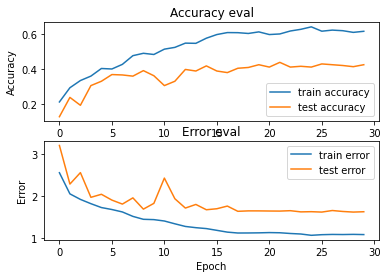

In [14]:
# plot accuracy/error for training and validation
plot_history(history)

In [15]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)

24/24 - 2s - loss: 1.6328 - accuracy: 0.4452

Test accuracy: 0.4451962113380432
Target: 0, Predicted label: [2]
